In [1]:
from gammapy.maps import Map, WcsGeom
from pathlib import Path
from astropy.io import fits
from astropy.visualization import simple_norm
from regions import RectangleSkyRegion
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.estimators import ImageProfileEstimator
from gammapy.data import EventList
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter

In [2]:
PATH = Path("../../results/e0102-zoom-a/jolideco/")

In [3]:
filenames = list(PATH.glob("iter-*/e0102-zoom-a-iter-*-result-jolideco.fits"))

In [4]:
filenames_counts = list(PATH.glob("iter-*/e0102-zoom-a-iter-*-result-jolideco-counts.fits"))

In [20]:
filenames_events = list(PATH.parent.glob("*/events/e0102-zoom-a-*-events.fits"))

In [5]:
geom_ref = Map.read(PATH.parent / "1308/maps/e0102-zoom-a-1308-counts.fits").geom.upsample(2)

Set MJD-END to 51888.371782 from DATE-END'. [astropy.wcs.wcs]


In [6]:

center = SkyCoord(16.0172, -72.0340, unit="deg")

region = RectangleSkyRegion(
    center=center,
    width=5 * u.arcsec,
    height=0.6 * u.arcsec,
    angle=45 * u.deg,
)

In [21]:
profile_geom = WcsGeom.create(
    skydir=region.center,
    width=(region.height, region.width),
    binsz=0.02 * u.arcsec,
    frame="galactic",
)

profile_geom.wcs.wcs.crota = [45, 45]


def read_map(filename, hdu):
    """Read map from FITS file"""
    with fits.open(filename) as hdulist:
        hdu = hdulist[hdu]
        data = hdu.data
    
    return Map.from_geom(geom_ref, data=data)


def measure_profile(flux, counts=False):
    """Measure profile"""

    geom = profile_geom
    
    flux_rotated = flux.interp_to_geom(geom)

    est = ImageProfileEstimator(axis="lat", method="mean")
    
    return est.run(flux_rotated).normalize("integral")


def measure_profiles_all(filenames, hdu="E0102"):
    """Measure profiles"""
    profiles = []

    for filename in filenames:
        m = read_map(filename, hdu=hdu)
        profile = measure_profile(m)
        profiles.append(profile)

    return profiles


def get_mean_and_std(profiles):
    profile_data = np.array([_.table["profile"].quantity for _ in profiles])
    return {
        "x": profiles[0].table["x_ref"],
        "mean": profile_data.mean(axis=0),
        "std": profile_data.std(axis=0),
    }


def wcs_from_header_chandra(header, x_col=11):
    """Create WCS from event file header

    Parameters
    ----------
    header : `~astropy.io.fits.Header`
        FITS header

    Returns
    -------
    wcs : `~astropy.wcs.WCS`
        WCS object
    """
    y_col = x_col + 1
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [header[f"TCRPX{x_col}"], header[f"TCRPX{y_col}"]]
    wcs.wcs.cdelt = [header[f"TCDLT{x_col}"], header[f"TCDLT{y_col}"]]
    wcs.wcs.crval = [header[f"TCRVL{x_col}"], header[f"TCRVL{y_col}"]]
    wcs.wcs.ctype = [header[f"TCTYP{x_col}"], header[f"TCTYP{y_col}"]]
    return wcs


def read_event_list_chandra(filename, hdu="EVENTS"):
    """Read event list"""
    hdu = fits.open(filename)[hdu]

    table = Table.read(hdu)

    wcs = wcs_from_header_chandra(header=hdu.header)

    for colname in table.colnames:
        table.rename_column(colname, colname.upper())

    ra, dec = wcs.wcs_pix2world(table["X"], table["Y"], 1)
    table["RA"] = ra * u.deg
    table["DEC"] = dec * u.deg

    mjd = table.meta["MJDREF"]
    mjd_int = np.floor(mjd).astype(np.int64)
    table.meta["MJDREFI"] = mjd_int
    table.meta["MJDREFF"] = mjd - mjd_int
    table.meta["TIMESYS"] = "tt"  # TODO: not sure tt is correct here...
    return EventList(table)



In [22]:
counts_stacked = Map.from_geom(geom_ref)


for filename in filenames_events:
    counts_stacked.fill_events(read_event_list_chandra(filename))

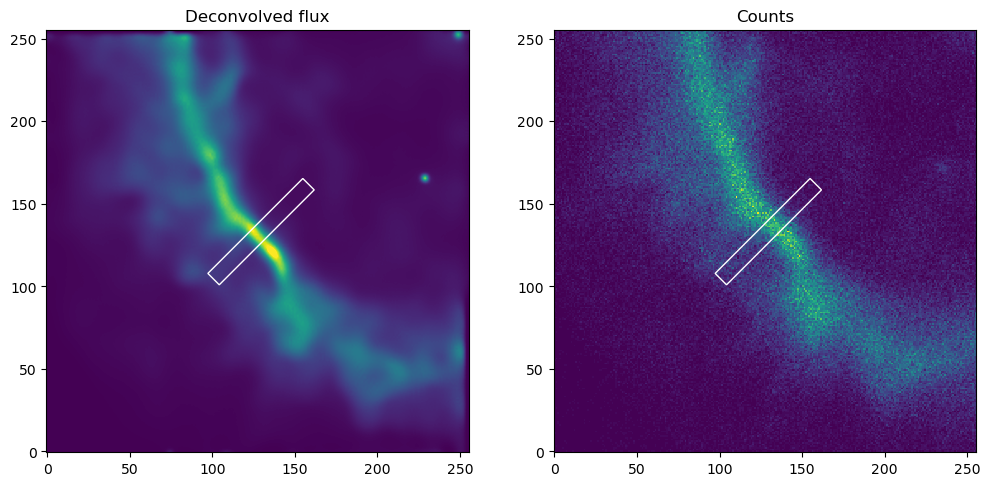

In [26]:
m = read_map(filenames[0], hdu="E0102")

norm = simple_norm(
    m.data,
    min_cut=0,
    max_cut=4,
    stretch="linear",
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

m.plot(ax=axes[0], cmap="viridis", norm=norm, interpolation="gaussian")
region_pix = region.to_pixel(m.geom.wcs)
axes[0].add_artist(region_pix.as_artist(facecolor="none", edgecolor="white", lw=1))
axes[0].set_title("Deconvolved flux")

counts_stacked.plot(ax=axes[1], cmap="viridis", interpolation="none")
axes[1].add_artist(region_pix.as_artist(facecolor="none", edgecolor="white", lw=1))
axes[1].set_title("Counts")

plt.savefig("/Users/adonath/Desktop/e0102-zoom-a-1308-region.png", dpi=300)

In [62]:
profiles_jolideco = measure_profiles_all(filenames)
d = get_mean_and_std(profiles_jolideco)

In [63]:

def plot_profile(ax, d, offset, label):
    x = (d["x"] - offset).quantity.to_value("arcsec")
    ax.plot(x, d["mean"], label=label)
    ax.fill_between(x, d["mean"] - 3 * d["std"], d["mean"] + 3 * d["std"], alpha=0.2)



In [64]:
def measure_profiles_all_events(filenames):
    """Measure profiles"""
    profiles = []

    m = Map.from_geom(profile_geom.downsample(2))

    for filename in filenames:
        m.fill_events(read_event_list_chandra(filename))
        
    profile = measure_profile(m)
    profiles.append(profile)

    return profiles


In [65]:
profiles_counts = measure_profiles_all_events(filenames_events)

In [66]:
#profiles_counts = [_.smooth("gauss", 0.01 * u.arcsec) for _ in profiles_counts]

In [67]:
d_counts = get_mean_and_std(profiles_counts)

In [68]:
def measure_fwhm(d, offset):
    from scipy.interpolate import UnivariateSpline
    x = (d["x"] - offset).quantity.to_value("arcsec")
    y = d["mean"]

    # create a spline of x and blue-np.max(blue)/2 
    y_half = y - np.max(y) / 2
    spline = UnivariateSpline(x, y_half, s=0)
    r1, r2 = spline.roots() # find the roots
    return r1, r2, np.max(y) / 2.


def plot_fwhm(ax, d, offset, color):
    r1, r2, y_max_half = measure_fwhm(d, offset)

    ax.annotate(text="", xy=(r1, y_max_half), xytext=(r2, y_max_half), color=color, arrowprops=dict(arrowstyle='<->', color=color))
    ax.text((r1 + r2) / 2, y_max_half* 0.98, f"$\lambda_{{fwhm}}$={r2 - r1:.2f}", ha="center", va="top", color=color)



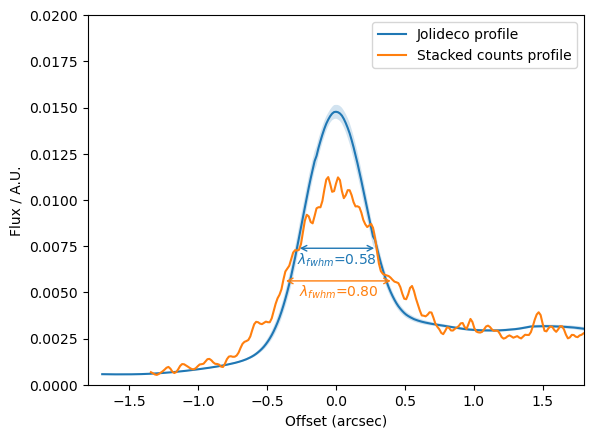

In [69]:
ax = plt.subplot(111)

offset = d["x"][np.argmax(d["mean"])]
plot_profile(ax, d, offset=offset, label="Jolideco profile")
plot_fwhm(ax, d, offset=offset, color="tab:blue")

smoothed = gaussian_filter(d_counts["mean"], sigma=2.)
offset = d_counts["x"][np.argmax(smoothed)]
plot_profile(ax, d_counts, offset=offset, label="Stacked counts profile")
plot_fwhm(ax, d_counts, offset=offset, color="tab:orange")
#ax.plot(d["x"] - offset, smoothed)

ax.set_xlabel("Offset (arcsec)")
plt.ylabel("Flux / A.U.")
plt.legend()
ax.set_ylim(0, 0.02)
ax.set_xlim(-1.8, 1.8)
plt.savefig("/Users/adonath/Desktop/e0102-zoom-a-1308-profile.png", dpi=300)

In [74]:
profile_data = []

for profile in profiles_jolideco:
    profile_data.append({"x": profile.table["x_ref"], "mean": profile.table["profile"]})

offset = d["x"][np.argmax(d["mean"])]

def get_fwhm(d, offset):
    r1, r2, y_max_half = measure_fwhm(d, offset)
    return r2 - r1
    

fwhms = [get_fwhm(d, offset) for d in profile_data]

In [78]:
print(f"Mean: {np.mean(fwhms):.3f}")
print(f"Std: {np.std(fwhms):.3f}")

Mean: 0.581
Std: 0.004


In [ ]:
0.581 / 0.004 

Notes:
- Error seems to small...
- Is is the boostrapping method?
- Is it the patch prior?